# STOCK TRADING

Car racing agent based on PPO

In [1]:
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from scipy import signal
import matplotlib.pyplot as plt

from PPO.ppo import PPO

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from core.market_env_v1 import MarketEnvironmentV1
from utils.networks import get_session

Using TensorFlow backend.


In [2]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Hyperparameters

In [3]:
### MODEL HYPERPARAMETERS
seq_len = 100
num_cols = 9 # OHLC and others

# Here our possible actions
sit = [1, 0, 0]
buy = [0, 1, 0]
sell = [0, 0, 1]
possible_actions = [sit, buy, sell]
state_size = (5, 1) # (close, open, high, low, )
action_size = 3              # 3 possible actions: sit, buy, sell

# Learning Hyper parameters
learning_rate =  0.001
reward_function =  'SimpleProfit' # policy function

### TRAINING HYPERPARAMETERS
total_episodes = 5000
batch_size = 1024

# Exploration parameters for epsilon greedy strategy
explore_start = 0.6            # exploration probability at start
explore_stop = 0.1            # minimum exploration probability 
decay_rate = 0.01            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.999               # Discounting rate


### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 20000          # Number of experiences the Memory can keep

### PPO Params
profit_window_size = 10
close_col = 3
buffer_size = 1024
epochs = 10
initial_cash = 5.0
loss_clipping = 0.2
noise = 1.0
entropy_loss = 5e-3

gpu = True
gather_stats = True
env_name = 'Market'
type = 'PPO'
consecutive_frames = 4


### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## Environment

In [4]:
!pip install gym[box2d]
# !conda install -c anaconda swig

     |████████████████████████████████| 448 kB 2.1 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [22]:
import gym
import numpy as np
from collections import deque

class Environment(object):
    """ Environment Helper Class (Multiple State Buffer) for Continuous Action Environments
    (MountainCarContinuous-v0, LunarLanderContinuous-v2, etc..), and MujuCo Environments
    """
    def __init__(self, gym_env):
        self.env = gym.make(gym_env)
        self.gym_actions = 2
        #self.id = gym_env.unwrapped.spec.id

    def get_action_size(self):
        return self.env.action_space.n

    def get_state_size(self):
        return self.env.observation_space.shape

    def reset(self):
        return self.env.reset()

    def step(self, action, debug=False):
        return self.env.step(action)

    def render(self):
        return self.env.render()

    # Dummy functions
    def get_info(self):
        return {}
    
    def get_state(self, integer):
        return None

    def close(self): self.env.close()

In [23]:
# Environment Initialization
env = Environment('CarRacing-v0')
env.reset()
#state_dim = env.get_state_size()[0]
#action_dim = env.get_action_size()

Track generation: 1047..1313 -> 266-tiles track


ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

## Init logs

In [13]:
tensorboard_logs = type + "/tensorboard_" + env_name + "_v0.3"

In [14]:
!mkdir $tensorboard_logs

# Clear any logs from previous runs
import shutil
shutil.rmtree(tensorboard_logs)

mkdir: cannot create directory ‘PPO/tensorboard_Market_v0.3’: File exists


In [15]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(tensorboard_logs)

## Setting up the algo

In [16]:
layers = [
			{
				"type": "dense",
				"neurons": 32,
				"activation": "tanh",
				"is_input": True
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 128
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 256
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 128
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 32
			},
			{
				"type": "dense",
				"is_output": True,
				"activation": "softmax"
			}
		]

In [17]:
algo = PPO(action_dim, state_dim, consecutive_frames, 
           lr=learning_rate, gamma=gamma, layers=layers,
          loss_clipping=loss_clipping, noise=noise, entropy_loss=entropy_loss)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
actor_input (Dense)          (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
actor_output (Dense)         (None, 3)                 99        
Total

## Training

rewards, actor_losses, critic_losses = algo.train(env, summary_writer, debug=False, 
                    batch_size=batch_size, buffer_size=buffer_size, epochs=epochs, nb_episodes=total_episodes)

In [19]:
rewards = algo.batch_rewards

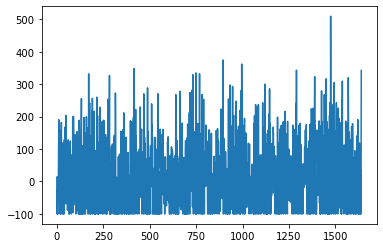

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.array(rewards).clip(-1e2,1e4))
plt.show()

In [21]:
import datetime
now = datetime.datetime.now().strftime("%S-%M-%H_%d-%m-%Y")
weights_filename = "saved_models/PPO_" + now + "_"
algo.save_weights(weights_filename)

## TEsting

In [22]:
args = {
    'x': x_train, 
    'actions': possible_actions, 
    'state_size': state_size, 
    'start_index': 0,
    'end_index': 5000,
    'close_col': close_col, 
    'undo_detrend': OHLC, 
    'profit_window_size': profit_window_size, 
}
env = MarketEnvironmentV1(**args)

In [23]:
algo = PPO(action_dim, state_dim, consecutive_frames, is_eval=True,
           lr=learning_rate, gamma=gamma, layers=layers,
          loss_clipping=loss_clipping, noise=noise, entropy_loss=entropy_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
actor_input (Dense)          (None, 32)                192       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
actor_output (Dense)         (None, 3)                 99        
Total para

In [24]:
weights_filename

'saved_models/PPO_01-24-10_14-09-2021_'

In [25]:
algo.load_weights(
    "saved_models/PPO_01-24-10_14-09-2021__LR_0.001_actor.h5", 
    "saved_models/PPO_01-24-10_14-09-2021__LR_0.001_critic.h5"
)

In [26]:
def buy():
    states_sell = []
    states_buy = []
    close = []
    
    observation = env.reset()
    done = False
    t = 0 

    while not done:
        close.append(env.get_last_close())
        action = algo.policy_action(np.array(observation))
        if action == 1: states_buy.append(t)
        if action == 2: states_sell.append(t)
            
        observation, r, done, _ = env.step(action)
        
        t += 1
        
    info = env.get_info()
    return close, states_buy, states_sell

In [27]:
close, states_buy, states_sell = buy()

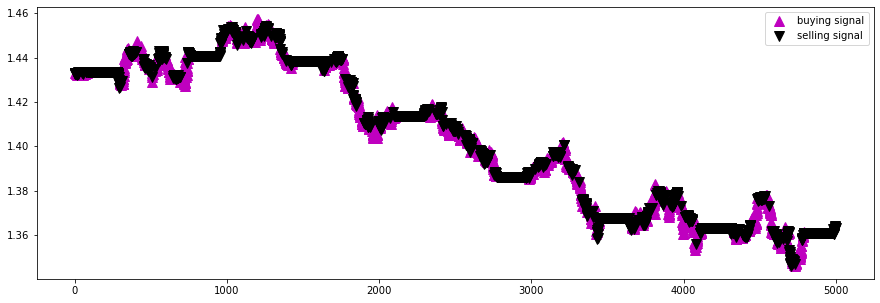

In [28]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()